In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

# Splitting into training and test set
from sklearn.model_selection import train_test_split

# Visualization
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Existing Classifiers and evaluation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

# Files
import selfmadeclassifiers as smc
import selfmadeevaluator as sme

# Wine Dataset

In [2]:
data = np.genfromtxt("wine_dataset_small.csv", delimiter=",", dtype=float, names=True)

feature_names = list(data.dtype.names[:-1])
target_name = data.dtype.names[-1]

X = np.array([data[feature] for feature in feature_names]).T
y = data[target_name].astype(int)

print(f"Feature columns names: {feature_names}")
print(f"Target column name: {target_name}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Feature columns names: ['citric_acid', 'residual_sugar', 'pH', 'sulphates', 'alcohol']
Target column name: type
X shape: (500, 5)
y shape: (500,)


In [3]:
wine_df=pd.DataFrame(data)
wine_df

,citric_acid,residual_sugar,pH,sulphates,alcohol,type
0,0.13,1.60,3.34,0.59,9.2,1.0
1,0.10,2.80,3.60,0.66,10.2,1.0
2,0.32,1.90,3.20,0.55,9.5,1.0
3,0.29,13.65,3.00,0.60,9.5,0.0
4,0.26,2.00,3.41,0.74,9.2,1.0
...,...,...,...,...,...,...
495,0.32,4.20,3.24,0.43,11.3,0.0
496,0.29,1.00,3.36,0.48,11.4,0.0
497,0.36,7.00,3.04,0.32,11.0,0.0
498,0.42,2.10,3.11,0.78,12.4,1.0


In [4]:
# Separate wine type out
features = wine_df.columns[:-1]
target = wine_df.columns[-1]

## Histogram

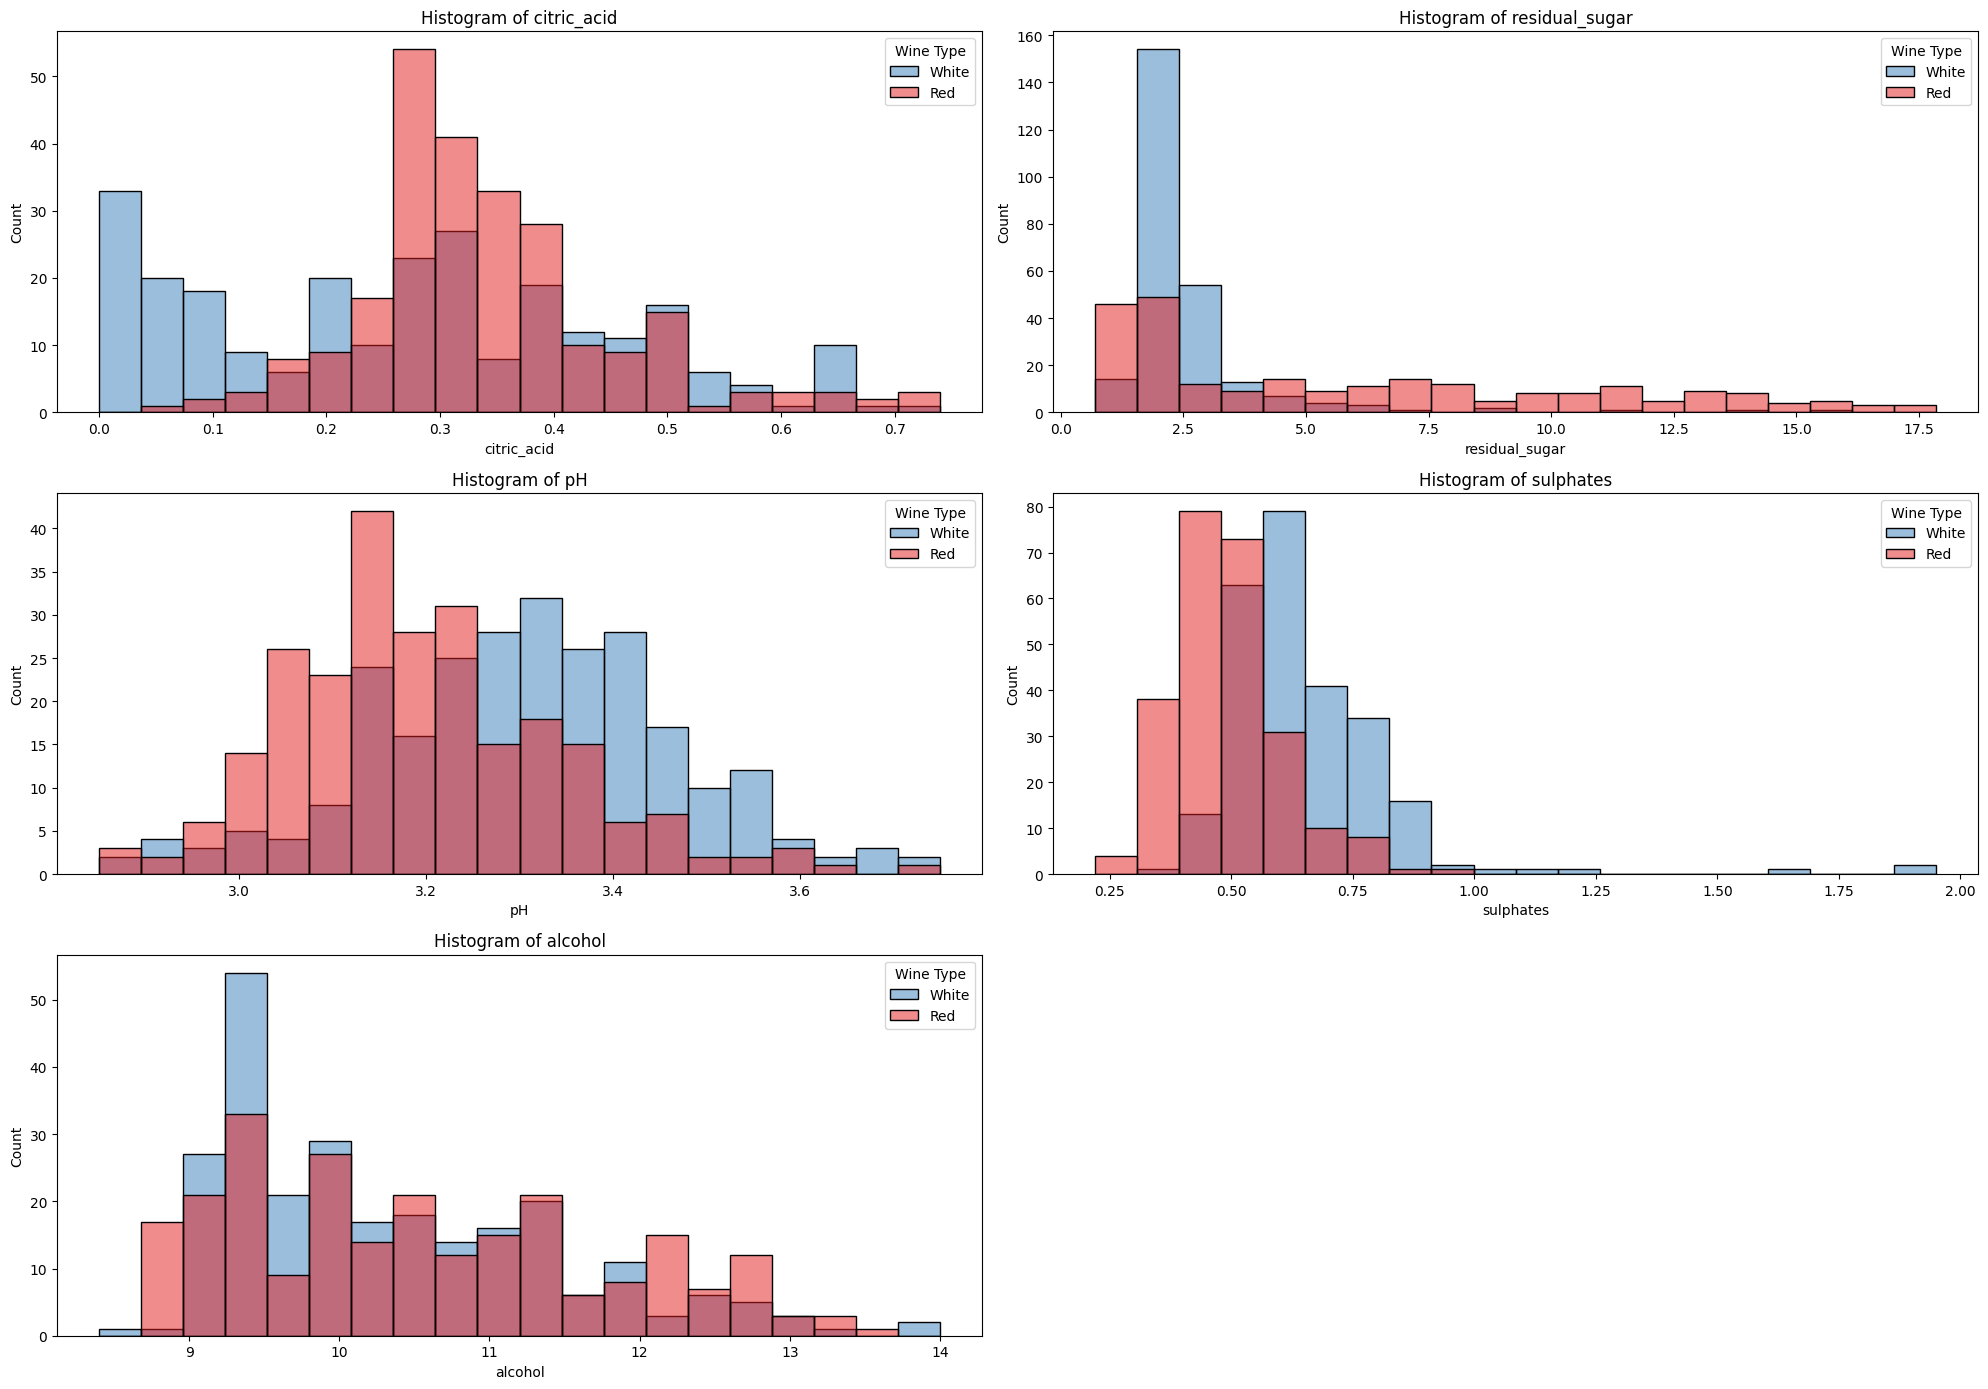

In [19]:
# Create the figure and axes for the grid
fig, axes = plt.subplots(3, 2, figsize=(20, 14))
axes = axes.flatten()

# Plot histograms in the grid
for i, feature in enumerate(features):
    sns.histplot(data=wine_df, x=feature, hue=target, kde=False, palette='Set1', bins=20, ax=axes[i])
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Wine Type', labels=['White', 'Red'])

# Adjust layout to prevent overlapping
axes[5].axis('off') # Hide 6th axes
plt.tight_layout()
plt.savefig('wine_histograms.pdf')
plt.show()

## Box plot

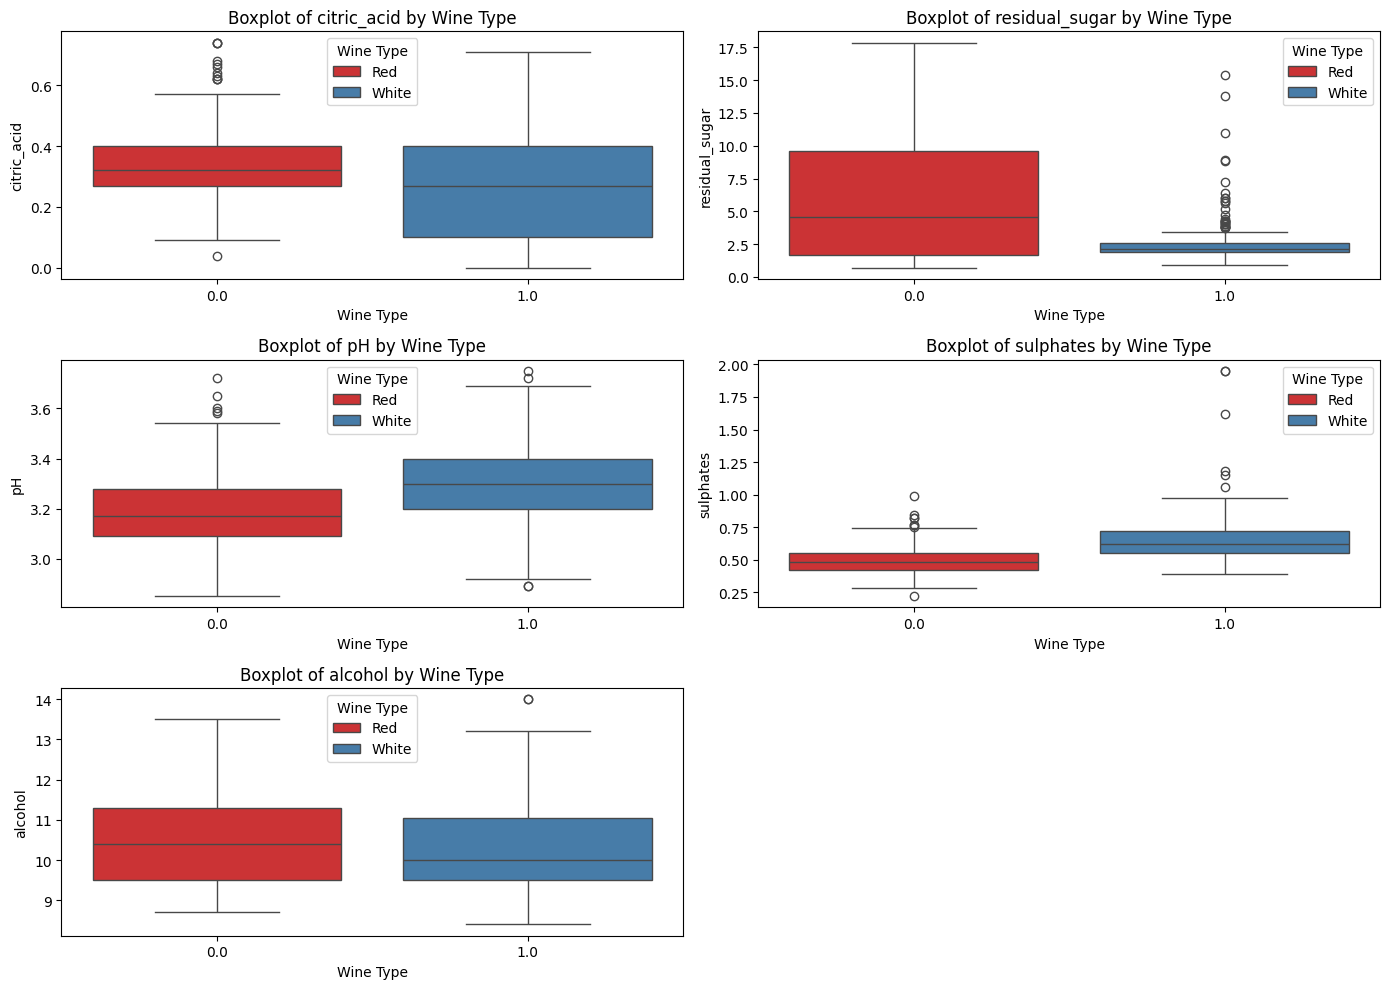

In [20]:
# Create the figure and axes for the grid
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(data=wine_df, x=target, y=feature, hue=target, palette='Set1', ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature} by Wine Type')
    axes[i].set_xlabel('Wine Type')
    axes[i].set_ylabel(feature)
    axes[i].legend(title='Wine Type', labels=['Red', 'White'])

# Adjust layout to prevent overlapping
axes[5].axis('off') # Hide 6th axes
plt.tight_layout()
plt.savefig('wine_box_plots.pdf')
plt.show()

In [ ]:
%%sql


# Preprocessing

In [7]:
# GridSearchCV and ClassifierEval splits the data up internally into training sets and test sets. By splitting the set out here we effectively make the classes use training and validation sets, letting us select the best hyperparameters before we test it on unseen data.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Decision Trees

In [8]:
# Setting up hyperparameters
dt_hyperparameter_values = {
    'max_depth': [2, 4, 6, 8, 10, 15, None],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
    'random_state': [42]
}

# Evaluating self-made decision tree with self-made grid-search.
sm_dt_evaluation = sme.ClassifierEval(
    clf= smc.DecisionTree,
    hyperparameter_grid= dt_hyperparameter_values,
    x = X_train,
    y = y_train,
    eval_method = 'cross-validation',
    scoring_method = 'accuracy',
    cv_folds = 10,
    random_state = 42
)
sm_dt_evaluation.evaluate()
best_sm_dt_hyperparams = sm_dt_evaluation.get_best_hyperparameters()
best_sm_dt_hyperparams

{'max_depth': 10,
 'criterion': 'entropy',
 'max_features': None,
 'random_state': 42}

In [9]:
# Self-made decision tree evaluation
sm_dt_evaluated_models = pd.DataFrame(sm_dt_evaluation.get_evaluated_models(sort_by_score=True, ascending=False))
sm_dt_evaluated_models.head(5)

,max_depth,criterion,max_features,random_state,accuracy_score
0,10.0,entropy,None,42,0.8300
1,6.0,gini,None,42,0.8225
2,10.0,gini,log2,42,0.8200
3,15.0,entropy,None,42,0.8200
4,6.0,entropy,None,42,0.8175


In [10]:
# Evaluating sklearn decision tree with GridSearchCV
sk_dt_gridsearch = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=dt_hyperparameter_values,
    cv = 10,
    scoring = 'accuracy',
)
sk_dt_gridsearch.fit(X_train, y_train)
best_sk_dt_hyperparams = sk_dt_gridsearch.best_params_
best_sk_dt_hyperparams

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'random_state': 42}

In [11]:
# Compare accuracies during gridsearch
print("Self-made decision tree best score: ", sm_dt_evaluation.get_best_score())
print("")
print("Sklearn decision tree best score: ", sk_dt_gridsearch.best_score_)

Self-made decision tree best score:  0.8299999999999998

Sklearn decision tree best score:  0.835


# Random Forests

In [12]:
# Parameter grid for random forest model evaluation
rf_hyperparameter_values = {
    'n_estimators': [10, 25, 75, 100, 150, 200, 250],
    'max_depth': [2, 4, 6, 8, 10, 15, None],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None],
    'random_state': [42]
}

# Evaluating self-made random forest with self-made grid-search.
sm_rf_evaluation = sme.ClassifierEval(
    clf= smc.RandomForest,
    hyperparameter_grid= rf_hyperparameter_values,
    x = X_train,
    y = y_train,
    eval_method = 'cross-validation',
    scoring_method = 'accuracy',
    cv_folds = 10,
    random_state = 42
)
sm_rf_evaluation.evaluate()
best_sm_rf_hyperparams = sm_rf_evaluation.get_best_hyperparameters()
best_sm_rf_hyperparams

{'n_estimators': 200,
 'max_depth': 10,
 'criterion': 'entropy',
 'max_features': 'sqrt',
 'random_state': 42}

In [13]:
# Self-made decision tree evaluation
sm_rf_evaluated_models = pd.DataFrame(sm_rf_evaluation.get_evaluated_models(sort_by_score=True, ascending=False))
sm_rf_evaluated_models.head(5)


,n_estimators,max_depth,criterion,max_features,random_state,accuracy_score
0,200,10.0,entropy,sqrt,42,0.8875
1,100,15.0,entropy,sqrt,42,0.8850
2,200,NaN,entropy,log2,42,0.8850
3,250,8.0,gini,sqrt,42,0.8825
4,75,8.0,entropy,log2,42,0.8825


In [14]:
# Evaluating sklearn random forest with GridSearchCV
sk_rf_gridsearch = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_hyperparameter_values,
    cv = 10,
    scoring = 'accuracy',
    n_jobs=-1
)
sk_rf_gridsearch.fit(X_train, y_train)
best_sk_rf_hyperparams = sk_rf_gridsearch.best_params_
best_sk_rf_hyperparams

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'sqrt',
 'n_estimators': 25,
 'random_state': 42}

In [15]:
# Compare accuracies during gridsearch
print("Self-made random forest best score: ", sm_rf_evaluation.get_best_score())
print("Sklearn random forest best score: ", sk_rf_gridsearch.best_score_)

Self-made random forest best score:  0.8875
Sklearn random forest best score:  0.8825


# Finalizing model and comparing

In [16]:
# Self-made decision Tree
sm_dt_clf = smc.DecisionTree(**best_sm_dt_hyperparams)
sm_dt_clf.fit(X_train, y_train)
sm_dt_clf_predictions = sm_dt_clf.predict(X_test)
sm_dt_clf_score = accuracy_score(y_test, sm_dt_clf_predictions)

# sklearn decision Tree
sk_dt_clf = DecisionTreeClassifier(**best_sk_dt_hyperparams)
sk_dt_clf.fit(X_train, y_train)
sk_dt_clf_predictions = sk_dt_clf.predict(X_test)
sk_dt_clf_score = accuracy_score(y_test, sk_dt_clf_predictions)

# Self-made random forest
sm_rf_clf = smc.RandomForest(**best_sm_rf_hyperparams)
sm_rf_clf.fit(X_train, y_train)
sm_rf_clf_predictions = sm_rf_clf.predict(X_test)
sm_rf_clf_score = accuracy_score(y_test, sm_rf_clf_predictions)

# sklearn random forest
sk_rf_clf = RandomForestClassifier(**best_sk_rf_hyperparams)
sk_rf_clf.fit(X_train, y_train)
sk_rf_clf_predictions = sk_rf_clf.predict(X_test)
sk_rf_clf_score = accuracy_score(y_test, sk_rf_clf_predictions)

In [17]:
print("Best evaluation model results:")
print("Self-made decision tree score: ",  sm_dt_evaluation.get_best_score())
print("Sklearn decision tree score: ", sk_dt_gridsearch.best_score_)
print("")
print("Self-made random forest score: ", sm_rf_evaluation.get_best_score())
print("Sklearn random forest score: ", sk_rf_gridsearch.best_score_)
print("")
print("")
print("Final model results:")
print("Self-made decision tree score: ", sm_dt_clf_score )
print("Sklearn decision tree score: ", sk_dt_clf_score)
print("")
print("Self-made random forest score: ", sm_rf_clf_score)
print("Sklearn random forest score: ", sk_rf_clf_score)

Best evaluation model results:
Self-made decision tree score:  0.8299999999999998
Sklearn decision tree score:  0.835

Self-made random forest score:  0.8875
Sklearn random forest score:  0.8825


Final model results:
Self-made decision tree score:  0.77
Sklearn decision tree score:  0.78

Self-made random forest score:  0.85
Sklearn random forest score:  0.89
